In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('^HSI','2019-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_21741/178164014.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


Open          High           Low         Close  \
Date                                                                 
2019-01-02  25824.439453  25824.439453  25055.269531  25130.349609   
2019-01-03  25077.679688  25262.210938  24896.869141  25064.359375   
2019-01-04  24946.119141  25626.029297  24924.730469  25626.029297   
2019-01-07  26015.839844  26043.640625  25753.460938  25835.699219   
2019-01-08  25852.500000  25960.890625  25688.500000  25875.449219   
...                  ...           ...           ...           ...   
2021-12-24  23375.990234  23383.189453  23186.570312  23223.759766   
2021-12-28  23282.349609  23319.439453  23099.480469  23280.560547   
2021-12-29  23253.980469  23253.980469  23008.279297  23086.539062   
2021-12-30  23130.449219  23248.259766  22990.240234  23112.009766   
2021-12-31  23553.789062  23590.119141  23394.769531  23397.669922   

               Adj Close  
Date                      
2019-01-02  25130.349609  
2019-01-03  25064.359375  
2019-01-04  25626.029297  
2019-01-07  25835.699219  
2019-01-08  25875.449219  
...                  ...  
2021-12-24  23223.759766  
2021-12-28  23280.560547  
2021-12-29  23086.539062  
2021-12-30  23112.009766  
2021-12-31  23397.669922  

[741 rows x 5 columns]

In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_21741/1968958741.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])


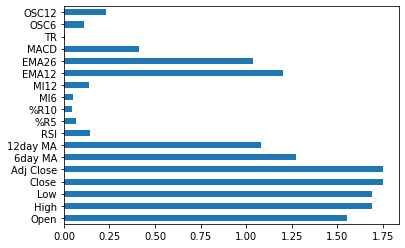

In [4]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [5]:
data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_21741/244261082.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)


Open          High           Low         Close  \
Date                                                                 
2021-12-23  23141.789062  23264.750000  23027.150391  23193.640625   
2021-12-24  23375.990234  23383.189453  23186.570312  23223.759766   
2021-12-28  23282.349609  23319.439453  23099.480469  23280.560547   
2021-12-29  23253.980469  23253.980469  23008.279297  23086.539062   
2021-12-30  23130.449219  23248.259766  22990.240234  23112.009766   

               Adj Close       6day MA      12day MA         EMA12  \
Date                                                                 
2021-12-23  23193.640625  23113.381836  23494.919108  23394.847996   
2021-12-24  23223.759766  23071.425130  23430.493327  23368.526730   
2021-12-28  23280.560547  23086.080078  23349.301758  23354.993471   
2021-12-29  23086.539062  23143.026693  23273.536621  23313.692793   
2021-12-30  23112.009766  23166.473307  23203.322428  23282.664635   

                   EMA26        MACD    Prediction  
Date                                                
2021-12-23  23829.572972 -434.724976  23223.759766  
2021-12-24  23784.697920 -416.171190  23280.560547  
2021-12-28  23747.354411 -392.360940  23086.539062  
2021-12-29  23698.405126 -384.712333  23112.009766  
2021-12-30  23654.968432 -372.303797  23397.669922

In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(485, 1, 10) (485,) (122, 1, 10) (122,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_21741/759405757.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
#     return_sequences=True,
#     kernel_regularizer=regularizers.l2(0.01)
   
))
# model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=128))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-13 18:47:21.183320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-13 18:47:21.183433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-13 18:47:22.169322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-13 18:47:22.909908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 18:47:23.057463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 18:47:24.786793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 698639936.0000

2022-04-13 18:47:26.290950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 18:47:26.338322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 5s 55ms/step - loss: 698639936.0000 - val_loss: 767239296.0000
Epoch 2/500
28/28 [==============================] - 0s 8ms/step - loss: 698580608.0000 - val_loss: 767104896.0000
Epoch 3/500
28/28 [==============================] - 0s 9ms/step - loss: 698419392.0000 - val_loss: 766647360.0000
Epoch 4/500
28/28 [==============================] - 0s 8ms/step - loss: 697934080.0000 - val_loss: 765379904.0000
Epoch 5/500
28/28 [==============================] - 0s 8ms/step - loss: 696755968.0000 - val_loss: 762646848.0000
Epoch 6/500
28/28 [==============================] - 0s 9ms/step - loss: 694430464.0000 - val_loss: 757806016.0000
Epoch 7/500
28/28 [==============================] - 0s 8ms/step - loss: 690521600.0000 - val_loss: 750386432.0000
Epoch 8/500
28/28 [==============================] - 0s 8ms/step - loss: 684713600.0000 - val_loss: 740136704.0000
Epoch 9/500
28/28 [==============================] - 0s 8ms/step - loss: 676842752.0000 - v

28/28 [==============================] - 0s 7ms/step - loss: 2765613.7500 - val_loss: 2243851.0000
Epoch 74/500
28/28 [==============================] - 0s 7ms/step - loss: 2680046.5000 - val_loss: 2207220.7500
Epoch 75/500
28/28 [==============================] - 0s 7ms/step - loss: 2597054.5000 - val_loss: 2170399.2500
Epoch 76/500
28/28 [==============================] - 0s 7ms/step - loss: 2516556.7500 - val_loss: 2133483.5000
Epoch 77/500
28/28 [==============================] - 0s 8ms/step - loss: 2438481.5000 - val_loss: 2096561.2500
Epoch 78/500
28/28 [==============================] - 0s 7ms/step - loss: 2362760.2500 - val_loss: 2059702.8750
Epoch 79/500
28/28 [==============================] - 0s 8ms/step - loss: 2289325.2500 - val_loss: 2022962.1250
Epoch 80/500
28/28 [==============================] - 0s 7ms/step - loss: 2218112.7500 - val_loss: 1986383.2500
Epoch 81/500
28/28 [==============================] - 0s 7ms/step - loss: 2149059.7500 - val_loss: 1950002.1250
Epoch

Epoch 220/500
28/28 [==============================] - 0s 8ms/step - loss: 158465.9688 - val_loss: 121145.6406
Epoch 221/500
28/28 [==============================] - 0s 8ms/step - loss: 157686.3438 - val_loss: 120782.2656
Epoch 222/500
28/28 [==============================] - 0s 8ms/step - loss: 156922.1562 - val_loss: 120441.2500
Epoch 223/500
28/28 [==============================] - 0s 9ms/step - loss: 156173.0312 - val_loss: 120121.5781
Epoch 224/500
28/28 [==============================] - 0s 9ms/step - loss: 155438.9688 - val_loss: 119822.3047
Epoch 225/500
28/28 [==============================] - 0s 11ms/step - loss: 154719.5938 - val_loss: 119542.6484
Epoch 226/500
28/28 [==============================] - 0s 7ms/step - loss: 154014.6719 - val_loss: 119281.4844
Epoch 227/500
28/28 [==============================] - 0s 8ms/step - loss: 153324.0625 - val_loss: 119038.3438
Epoch 228/500
28/28 [==============================] - 0s 9ms/step - loss: 152647.5781 - val_loss: 118812.2188


Epoch 294/500
28/28 [==============================] - 0s 8ms/step - loss: 129002.3125 - val_loss: 119949.8203
Epoch 295/500
28/28 [==============================] - 0s 7ms/step - loss: 128814.7031 - val_loss: 120005.2109
Epoch 296/500
28/28 [==============================] - 0s 7ms/step - loss: 128628.5859 - val_loss: 120058.5391
Epoch 297/500
28/28 [==============================] - 0s 9ms/step - loss: 128444.0078 - val_loss: 120109.9844
Epoch 298/500
28/28 [==============================] - 0s 8ms/step - loss: 128261.0234 - val_loss: 120159.8047
Epoch 299/500
28/28 [==============================] - 0s 7ms/step - loss: 128079.2891 - val_loss: 120207.3516
Epoch 300/500
28/28 [==============================] - 0s 7ms/step - loss: 127899.0000 - val_loss: 120253.1953
Epoch 301/500
28/28 [==============================] - 0s 8ms/step - loss: 127719.8516 - val_loss: 120297.0312
Epoch 302/500
28/28 [==============================] - 0s 8ms/step - loss: 127541.9141 - val_loss: 120338.5000
E

Epoch 368/500
28/28 [==============================] - 0s 7ms/step - loss: 117982.8906 - val_loss: 120085.8359
Epoch 369/500
28/28 [==============================] - 0s 7ms/step - loss: 117875.0312 - val_loss: 120058.5078
Epoch 370/500
28/28 [==============================] - 0s 8ms/step - loss: 117768.2969 - val_loss: 120031.4766
Epoch 371/500
28/28 [==============================] - 0s 7ms/step - loss: 117662.8125 - val_loss: 120004.3750
Epoch 372/500
28/28 [==============================] - 0s 7ms/step - loss: 117558.5781 - val_loss: 119976.7812
Epoch 373/500
28/28 [==============================] - 0s 9ms/step - loss: 117455.5312 - val_loss: 119949.4141
Epoch 374/500
28/28 [==============================] - 0s 8ms/step - loss: 117353.6016 - val_loss: 119922.0312
Epoch 375/500
28/28 [==============================] - 0s 7ms/step - loss: 117252.8438 - val_loss: 119894.4062
Epoch 376/500
28/28 [==============================] - 0s 7ms/step - loss: 117153.1641 - val_loss: 119866.9766
E

Epoch 442/500
28/28 [==============================] - 0s 9ms/step - loss: 112688.9844 - val_loss: 118464.1094
Epoch 443/500
28/28 [==============================] - 0s 7ms/step - loss: 112645.3516 - val_loss: 118451.8047
Epoch 444/500
28/28 [==============================] - 0s 7ms/step - loss: 112602.3672 - val_loss: 118439.8750
Epoch 445/500
28/28 [==============================] - 0s 7ms/step - loss: 112559.6328 - val_loss: 118427.7344
Epoch 446/500
28/28 [==============================] - 0s 7ms/step - loss: 112517.4531 - val_loss: 118416.4297
Epoch 447/500
28/28 [==============================] - 0s 7ms/step - loss: 112475.8672 - val_loss: 118405.1094
Epoch 448/500
28/28 [==============================] - 0s 7ms/step - loss: 112434.6406 - val_loss: 118393.6172
Epoch 449/500
28/28 [==============================] - 0s 7ms/step - loss: 112393.8906 - val_loss: 118382.5859
Epoch 450/500
28/28 [==============================] - 0s 7ms/step - loss: 112353.5547 - val_loss: 118372.4375
E

2022-04-13 18:49:11.008900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-13 18:49:11.056276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


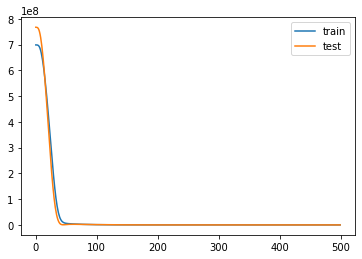

In [11]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

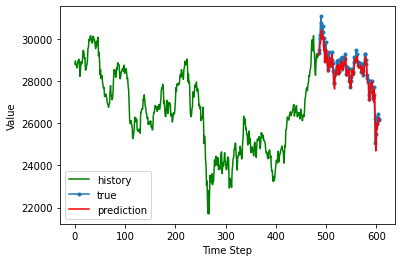

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

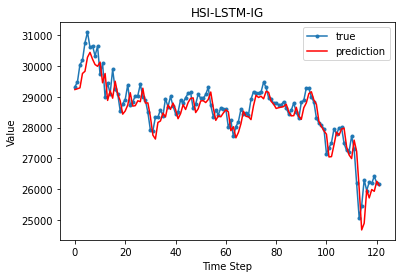

In [13]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-IG')
plt.legend()
plt.show();

In [14]:
r2_score(y_test,y_pred)

0.847498653432701

In [15]:
mean_absolute_percentage_error(y_test,y_pred)

0.011174345681623267

In [16]:
mean_squared_error(y_test,y_pred,squared=False)

407.77608152574345

In [17]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_21741/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


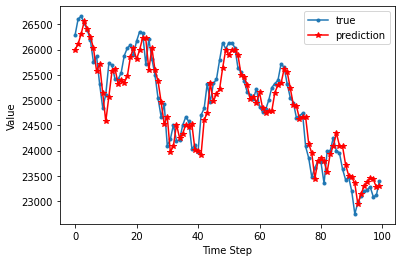

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.9037215968716963

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.0101766393232636

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

311.6982930616111